In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
os.chdir('..')
# sys.path.append(os.path.abspath(''))

### <span style="color: lightskyblue;"> Carga de datos </span>

In [3]:
import pandas as pd
from src.utils import clean_and_load
print(os.path.abspath('.'))
# hacer cd ..



trips_2020 = clean_and_load('data/raw/trips_2020.csv', drop_cols=['Unnamed: 0'])
trips_2021 = clean_and_load('data/raw/trips_2021.csv', drop_cols=['Unnamed: 0', 'genero'])  # eliminar segunda 'Género'
trips_2022 = clean_and_load('data/raw/trips_2022.csv', drop_cols=['Unnamed: 0', 'X'], rename_cols={'Género': 'genero'})
trips_2023 = clean_and_load('data/raw/trips_2023.csv', drop_cols=['Unnamed: 0'])
trips_2024 = clean_and_load('data/raw/trips_2024.csv')

trips_2020 = trips_2020[trips_2020['fecha_origen_recorrido'].dt.month > 8]

trips = pd.concat([trips_2020, trips_2021, trips_2022, trips_2023, trips_2024], ignore_index=True)

trips.to_csv('data/processed/trips.csv', index=False)

c:\Users\Matteo\Documents\Facultad\tercero\primercuatri\ML\ML\PF\proyecto_final


In [4]:

import pandas as pd

# Lista de archivos y si contienen o no la columna del DNI
user_files = [
    ('data/raw/usuarios_ecobici_2020.csv', True),
    ('data/raw/usuarios_ecobici_2021.csv', True),
    ('data/raw/usuarios_ecobici_2022.csv', True),
    ('data/raw/usuarios_ecobici_2023.csv', True),
    ('data/raw/usuarios_ecobici_2024.csv', False),  # este no tiene columna de DNI
]

user_dfs = []

for path, has_dni in user_files:
    df = pd.read_csv(path, parse_dates=['fecha_alta'])
    if has_dni:
        df.drop(columns=['Customer.Has.Dni..Yes...No.'], inplace=True)
    # Normalizar nombres de columnas
    df.columns = df.columns.str.lower().str.replace('.', '_').str.replace(' ', '').str.replace('__', '_')
    df = df.rename(columns={
        'id_usuario': 'id_usuario',
        'genero_usuario': 'genero_usuario',
        'edad_usuario': 'edad_usuario',
        'fecha_alta': 'fecha_alta',
        'hora_alta': 'hora_alta',
    })

    user_dfs.append(df)

# Concatenar todos los usuarios
usuarios = pd.concat(user_dfs, ignore_index=True)

# Convertir id_usuario a string para hacer merge correcto
usuarios['id_usuario'] = usuarios['id_usuario'].astype(float)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\2079243983.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, parse_dates=['fecha_alta'])


In [6]:
# Nos aseguramos que los id_usuario de trips también sean string
trips = pd.read_csv('data/processed/trips.csv')
trips['id_usuario'] = trips['id_usuario'].astype(float)
# usuarios edad entre 10 y 100
# Paso 1: Convertir todo a string
usuarios['edad_usuario'] = usuarios['edad_usuario'].astype(str)

# Paso 2: Eliminar comas, espacios y valores vacíos
usuarios['edad_usuario'] = usuarios['edad_usuario'].str.replace(',', '', regex=False).str.strip()

# Paso 3: Filtrar solo los valores que son dígitos (descarta "NaN", "dos mil", etc.)
usuarios = usuarios[usuarios['edad_usuario'].str.isdigit()]

# Paso 4: Convertir a int
usuarios['edad_usuario'] = usuarios['edad_usuario'].astype(int)

# Paso 5: Filtrar valores fuera del rango 10–100
usuarios = usuarios[(usuarios['edad_usuario'] >= 10) & (usuarios['edad_usuario'] <= 100)]



# Hacemos un left join: cada recorrido se enriquece con datos del usuario
trips_enriched = trips.merge(
    usuarios[['id_usuario', 'edad_usuario', 'fecha_alta', 'hora_alta']],
    on='id_usuario',
    how='left'
)
# trips_2024_filtered = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month <= 8]
# trips_2024_test = trips_2024[trips_2024['fecha_origen_recorrido'].dt.month >= 9]
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
trips_enriched_train = trips_enriched[trips_enriched['fecha_origen_recorrido'].dt.month <= 8]
trips_2024_test = trips_enriched[trips_enriched['fecha_origen_recorrido'].dt.month >= 9]
trips_enriched = trips_enriched_train
# df = df.groupby("nombre_estacion_origen").filter(
#     lambda x: x["direccion_estacion_origen"].nunique() > 1
# )
usuarios

C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\2247460405.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trips = pd.read_csv('data/processed/trips.csv')


,id_usuario,genero_usuario,edad_usuario,fecha_alta,hora_alta
0,735944.0,FEMALE,29,2020-12-31,20:19:04
1,735892.0,MALE,44,2020-12-31,11:24:04
2,735873.0,MALE,39,2020-12-31,09:28:27
3,735876.0,MALE,37,2020-12-31,09:49:30
4,735952.0,OTHER,29,2020-12-31,21:07:04
...,...,...,...,...,...
627876,1120417.0,FEMALE,45,2024-03-01,15:09:21
627877,1153589.0,MALE,55,2024-05-08,18:17:14
627878,1216661.0,MALE,25,2024-09-28,09:23:29
627879,1256657.0,MALE,24,2024-11-22,19:38:23


In [7]:
trips_enriched.to_csv('data/processed/trips_enriched.csv', index=False)
trips_2024_test.to_csv('data/processed/trips_2024_test.csv', index=False)

In [5]:
import pandas as pd

# trips_enriched = pd.read_csv('data/processed/trips_enriched.csv')
trips_enriched['fecha_origen_recorrido'] = pd.to_datetime(trips_enriched['fecha_origen_recorrido'])
trips_enriched['fecha_destino_recorrido'] = pd.to_datetime(trips_enriched['fecha_destino_recorrido'])
# trips_enriched.to_csv('data/processed/trips_enriched.csv', index=False)

C:\Users\Matteo\AppData\Local\Temp\ipykernel_22100\3433263776.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_enriched = pd.read_csv('data/processed/trips_enriched.csv')


## <span style="color: lightskyblue;"> 2. Transformación a Series Temporales (30 min) </span>

In [8]:
import pandas as pd
import numpy as np
from datetime import timedelta

def create_time_series_dataset_fast(trips_df, time_window_minutes=30):
    """
    Versión optimizada de transformación de dataset de viajes a series temporales.
    """
    trips_df = trips_df.copy()

    trips_df['fecha_origen_recorrido'] = pd.to_datetime(trips_df['fecha_origen_recorrido'])
    trips_df['fecha_destino_recorrido'] = pd.to_datetime(trips_df['fecha_destino_recorrido'])
    
    # 1. Crear columnas de ventana para despachos (origen) y arribos (destino)
    # trips_df['timestamp_origen_window'] = trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T')
    trips_df['timestamp_origen_window'] = (trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))

    trips_df['timestamp_destino_window'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T')
    trips_df['timestamp_destino_prev'] = (
    trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
    arribos_prev = trips_df.groupby(['timestamp_destino_prev','id_estacion_destino']).size().reset_index(name='arribos_prev_count').rename(columns={'timestamp_destino_prev':'timestamp','id_estacion_destino':'id_estacion'})

    # 2. Obtener rango de timestamps
    fecha_min = trips_df['timestamp_origen_window'].min()
    fecha_max = trips_df['timestamp_destino_window'].max()
    timestamps = pd.date_range(start=fecha_min, end=fecha_max, freq=f'{time_window_minutes}T')
    
    # 3. Obtener lista única de estaciones (origen + destino)
    estaciones_origen = trips_df[['id_estacion_origen', 'nombre_estacion_origen',
                                  'direccion_estacion_origen', 'lat_estacion_origen',
                                  'long_estacion_origen']].drop_duplicates()
    estaciones_destino = trips_df[['id_estacion_destino', 'nombre_estacion_destino',
                                   'direccion_estacion_destino', 'lat_estacion_destino',
                                   'long_estacion_destino']].drop_duplicates()

    estaciones_origen.columns = ['id_estacion', 'nombre_estacion', 'direccion_estacion', 'lat_estacion', 'long_estacion']
    estaciones_destino.columns = ['id_estacion', 'nombre_estacion', 'direccion_estacion', 'lat_estacion', 'long_estacion']
    
    estaciones = pd.concat([estaciones_origen, estaciones_destino]).drop_duplicates(subset=['id_estacion']).dropna(subset=['id_estacion'])

    print(f"Total de timestamps: {len(timestamps)}")
    print(f"Total de estaciones: {len(estaciones)}")
    
    # 4. Crear esqueleto base con producto cartesiano entre timestamps y estaciones
    timestamps_df = pd.DataFrame({'timestamp': timestamps})
    ts_grid = timestamps_df.assign(key=1).merge(estaciones.assign(key=1), on='key').drop(columns='key')

    # 5. Precalcular estadísticas históricas (ventana de despachos)
    despachos = trips_df.groupby(['timestamp_origen_window', 'id_estacion_origen']).agg(
        despachos_count=('id_estacion_origen', 'count'),
        duracion_recorrido_mean=('duracion_recorrido', 'mean'),
        duracion_recorrido_std=('duracion_recorrido', 'std'),
        duracion_recorrido_count=('duracion_recorrido', 'count'),
        edad_usuario_mean=('edad_usuario', 'mean'),
        edad_usuario_std=('edad_usuario', 'std'),
        proporcion_mujeres=('genero', lambda x: (x == 'F').sum() / len(x) if len(x) > 0 else 0),
        modelo_mas_comun=('modelo_bicicleta', lambda x: x.mode()[0] if len(x.mode()) > 0 else 'UNKNOWN')
    ).reset_index()

    despachos = despachos.rename(columns={
        'timestamp_origen_window': 'timestamp',
        'id_estacion_origen': 'id_estacion'
    })

    # 6. Precalcular arribos (ventana futura)
    arribos = trips_df.groupby(['timestamp_destino_window', 'id_estacion_destino']).size().reset_index(name='arribos_count')
    arribos = arribos.rename(columns={
        'timestamp_destino_window': 'timestamp',
        'id_estacion_destino': 'id_estacion'
    })

    # 7. Merge de todas las features al grid base
    ts_df = ts_grid.merge(despachos, on=['timestamp', 'id_estacion'], how='left')
    ts_df = ts_df.merge(arribos, on=['timestamp', 'id_estacion'], how='left')
    ts_df = ts_df.merge(arribos_prev, on=['timestamp','id_estacion'], how='left')
    ts_df['arribos_prev_count'] = ts_df['arribos_prev_count'].fillna(0).astype(int)

    # 8. Rellenar NaNs con valores por defecto
    ts_df['despachos_count'] = ts_df['despachos_count'].fillna(0).astype(int)
    ts_df['arribos_count'] = ts_df['arribos_count'].fillna(0).astype(int)
    ts_df['duracion_recorrido_mean'] = ts_df['duracion_recorrido_mean'].fillna(0)
    ts_df['duracion_recorrido_std'] = ts_df['duracion_recorrido_std'].fillna(0)
    ts_df['duracion_recorrido_count'] = ts_df['duracion_recorrido_count'].fillna(0).astype(int)
    ts_df['edad_usuario_mean'] = ts_df['edad_usuario_mean'].fillna(0)
    ts_df['edad_usuario_std'] = ts_df['edad_usuario_std'].fillna(0)
    ts_df['proporcion_mujeres'] = ts_df['proporcion_mujeres'].fillna(0)
    ts_df['modelo_mas_comun'] = ts_df['modelo_mas_comun'].fillna('UNKNOWN')

    # 9. Agregar variables temporales
    ts_df['hora'] = ts_df['timestamp'].dt.hour
    ts_df['dia_semana'] = ts_df['timestamp'].dt.dayofweek
    ts_df['es_fin_semana'] = (ts_df['dia_semana'] >= 5).astype(int)
    ts_df['mes'] = ts_df['timestamp'].dt.month
    ts_df['dia_mes'] = ts_df['timestamp'].dt.day
    ts_df['año'] = ts_df['timestamp'].dt.year

    print(f"\nDataset final:")
    print(f"Forma: {ts_df.shape}")
    print(f"Rango temporal: {ts_df['timestamp'].min()} a {ts_df['timestamp'].max()}")
    print(f"Estaciones únicas: {ts_df['id_estacion'].nunique()}")
    
            # 10. Crear columnas "prev_1" hasta "prev_6" para todas las features históricas
    features_to_shift = [
        'despachos_count', 'duracion_recorrido_mean', 'duracion_recorrido_std',
        'duracion_recorrido_count', 'edad_usuario_mean', 'edad_usuario_std',
        'proporcion_mujeres', 'arribos_count'
    ]

    ts_df = ts_df.sort_values(['id_estacion', 'timestamp'])

    # Crear columnas prev_1 a prev_6
    for lag in range(1, 7):  # De 1 a 6
        shifted = ts_df.groupby('id_estacion')[features_to_shift].shift(lag)
        shifted.columns = [f'{col}_prev_{lag}' for col in shifted.columns]
        ts_df = pd.concat([ts_df, shifted], axis=1)

    # Rellenar NaNs con valores neutros
    for col in ts_df.columns:
        if col.startswith(tuple(f"{f}_" for f in features_to_shift)) and col.endswith(tuple(f"_prev_{i}" for i in range(1, 7))):
            if ts_df[col].dtype == 'float':
                ts_df[col] = ts_df[col].fillna(0.0)
            else:
                ts_df[col] = ts_df[col].fillna(0)



    return ts_df

# Ejecutar transformación
print("Iniciando transformación de trips_enriched a series temporales...")
trips_enriched_ts = create_time_series_dataset_fast(trips_enriched, time_window_minutes=30)

# Guardar resultado
trips_enriched_ts.to_csv('data/processed/trips_enriched_timeseries.csv', index=False)
print(f"\nDataset guardado en: data/processed/trips_enriched_timeseries.csv")

trips_enriched_ts

Iniciando transformación de trips_enriched a series temporales...


C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\1835046342.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_origen_window'] = (trips_df['fecha_origen_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\1835046342.py:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['timestamp_destino_window'] = trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T')
C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\1835046342.py:20: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  trips_df['fecha_destino_recorrido'].dt.floor(f'{time_window_minutes}T') + pd.Timedelta(minutes=time_window_minutes))
C:\Users\Matteo\AppData\Local\Temp\ipykernel_29236\1835046342.py:26: FutureWarning: 'T' is deprecated an

Total de timestamps: 64929
Total de estaciones: 397

Dataset final:
Forma: (25776813, 22)
Rango temporal: 2021-01-01 00:30:00 a 2024-09-14 16:30:00
Estaciones únicas: 397

Dataset guardado en: data/processed/trips_enriched_timeseries.csv


,timestamp,id_estacion,nombre_estacion,direccion_estacion,lat_estacion,long_estacion,despachos_count,duracion_recorrido_mean,duracion_recorrido_std,duracion_recorrido_count,...,proporcion_mujeres_prev_5,arribos_count_prev_5,despachos_count_prev_6,duracion_recorrido_mean_prev_6,duracion_recorrido_std_prev_6,duracion_recorrido_count_prev_6,edad_usuario_mean_prev_6,edad_usuario_std_prev_6,proporcion_mujeres_prev_6,arribos_count_prev_6
13,2021-01-01 00:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
410,2021-01-01 01:00:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,2021-01-01 01:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,1,1606.0,0.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1204,2021-01-01 02:00:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1601,2021-01-01 02:30:00,2.0,002 - Retiro I,AV. Dr. José María Ramos Mejía 1300,-34.592422,-58.374710,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25775212,2024-09-14 14:30:00,556.0,230 - AREVALO,Arévalo 1408,-34.583614,-58.443604,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25775609,2024-09-14 15:00:00,556.0,230 - AREVALO,Arévalo 1408,-34.583614,-58.443604,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25776006,2024-09-14 15:30:00,556.0,230 - AREVALO,Arévalo 1408,-34.583614,-58.443604,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25776403,2024-09-14 16:00:00,556.0,230 - AREVALO,Arévalo 1408,-34.583614,-58.443604,0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:

import gc

gc.collect()

0

## <span style="color: lightskyblue;"> 3. Split Train/Val y Normalización </span>

In [4]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import random

def split_train_val_by_week(df, random_seed=42):
    """
    Separa los datos en train y val usando 1 día random por semana para validación.
    """
    
    # Establecer semilla para reproducibilidad
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    print("Iniciando separación train/val...")
    print(f"Dataset original: {df.shape}")
    print(f"Rango temporal: {df['timestamp'].min()} a {df['timestamp'].max()}")
    
    # Crear columnas auxiliares para la separación
    df_work = df.copy()
    df_work['fecha'] = df_work['timestamp'].dt.date
    df_work['año'] = df_work['timestamp'].dt.year
    df_work['mes'] = df_work['timestamp'].dt.month
    df_work['semana_año'] = df_work['timestamp'].dt.isocalendar().week
    df_work['dia_semana'] = df_work['timestamp'].dt.dayofweek  # 0=Lunes, 6=Domingo
    
    # Obtener todas las combinaciones únicas de año-mes-semana
    semanas_unicas = df_work[['año', 'mes', 'semana_año']].drop_duplicates()
    
    print(f"Total de semanas únicas: {len(semanas_unicas)}")
    
    # Para cada semana, seleccionar un día aleatorio para validación
    dias_val = []
    
    for _, semana in semanas_unicas.iterrows():
        año, mes, num_semana = semana['año'], semana['mes'], semana['semana_año']
        
        # Obtener todos los días de esta semana en este mes
        dias_semana = df_work[
            (df_work['año'] == año) & 
            (df_work['mes'] == mes) & 
            (df_work['semana_año'] == num_semana)
        ]['fecha'].unique()
        
        if len(dias_semana) > 0:
            # Seleccionar un día aleatorio de esta semana
            dia_seleccionado = random.choice(dias_semana)
            dias_val.append(dia_seleccionado)
            
    print(f"Días seleccionados para validación: {len(dias_val)}")
    
    # Crear máscaras para train y val
    mask_val = df_work['fecha'].isin(dias_val)
    mask_train = ~mask_val
    
    # Separar los datasets
    train_df = df_work[mask_train].drop(columns=['fecha', 'semana_año']).reset_index(drop=True)
    val_df = df_work[mask_val].drop(columns=['fecha', 'semana_año']).reset_index(drop=True)
    
    print(f"Dataset train: {train_df.shape} ({mask_train.sum()/len(df)*100:.1f}%)")
    print(f"Dataset val: {val_df.shape} ({mask_val.sum()/len(df)*100:.1f}%)")
    
    # Verificar que no hay solapamiento temporal
    train_dates = set(train_df['timestamp'].dt.date)
    val_dates = set(val_df['timestamp'].dt.date)
    overlap = train_dates.intersection(val_dates)
    
    if len(overlap) > 0:
        print(f"⚠️  ADVERTENCIA: Hay {len(overlap)} días que aparecen en ambos conjuntos")
    else:
        print("✅ Separación correcta: No hay solapamiento de días entre train y val")
        
    return train_df, val_df


In [4]:
def normalize_features(train_df, val_df, exclude_cols=None):
    """
    Normaliza las features numéricas usando StandardScaler.
    """
    
    if exclude_cols is None:
        exclude_cols = ['timestamp', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
    
    print("\nIniciando normalización...")
    
    # Identificar columnas numéricas para normalizar
    numeric_cols = []
    categorical_cols = []
    
    for col in train_df.columns:
        if col in exclude_cols:
            continue
        elif train_df[col].dtype in ['float64', 'float32', 'int64', 'int32']:
            numeric_cols.append(col)
        else:
            categorical_cols.append(col)
    
    print(f"Columnas numéricas a normalizar: {len(numeric_cols)}")
    print(f"Columnas categóricas (no normalizadas): {len(categorical_cols)}")
    print(f"Columnas excluidas: {len(exclude_cols)}")
    
    # Crear copias para no modificar los originales
    train_norm = train_df.copy()
    val_norm = val_df.copy()
    
    # Inicializar y ajustar el scaler SOLO con datos de train
    scaler = StandardScaler()
    
    if len(numeric_cols) > 0:
        # Fit del scaler solo en train
        scaler.fit(train_norm[numeric_cols])
        
        # Transform en ambos conjuntos
        train_norm[numeric_cols] = scaler.transform(train_norm[numeric_cols])
        val_norm[numeric_cols] = scaler.transform(val_norm[numeric_cols])
        
        print(f"✅ Normalización completada")
        print(f"   Media de features train (debe ser ~0): {train_norm[numeric_cols].mean().mean():.6f}")
        print(f"   Std de features train (debe ser ~1): {train_norm[numeric_cols].std().mean():.6f}")
    else:
        print("⚠️  No se encontraron columnas numéricas para normalizar")
    
    return train_norm, val_norm, scaler, numeric_cols

# Ejecutar separación y normalización
print("=" * 60)
print("SEPARACIÓN TRAIN/VAL Y NORMALIZACIÓN")
print("=" * 60)
trips_enriched_ts = pd.read_csv('data/processed/trips_enriched_timeseries.csv', parse_dates=['timestamp'])
# 1. Separar train/val
train_raw, val_raw = split_train_val_by_week(trips_enriched_ts, random_seed=42)

# train_raw.to_csv('data/processed/train_raw.csv', index=False)
# val_raw.to_csv('data/processed/val_raw.csv', index=False)


SEPARACIÓN TRAIN/VAL Y NORMALIZACIÓN
Iniciando separación train/val...
Dataset original: (25776813, 70)
Rango temporal: 2021-01-01 00:30:00 a 2024-09-14 16:30:00
Total de semanas únicas: 230
Días seleccionados para validación: 230
Dataset train: (21393933, 70) (83.0%)
Dataset val: (4382880, 70) (17.0%)
✅ Separación correcta: No hay solapamiento de días entre train y val


In [5]:

# 2. Normalizar features
train_norm, val_norm, scaler, numeric_columns = normalize_features(train_raw, val_raw)

# 3. Guardar resultados
# train_norm.to_csv('data/processed/train_normalized.csv', index=False)
# val_norm.to_csv('data/processed/val_normalized.csv', index=False)

print(f"\n📁 Archivos guardados:")
print(f"   Train: data/processed/train_normalized.csv")
print(f"   Val: data/processed/val_normalized.csv")

# 4. Mostrar estadísticas finales
print(f"\n📊 Resumen final:")
print(f"   Train: {train_norm.shape[0]:,} filas × {train_norm.shape[1]:,} columnas")
print(f"   Val: {val_norm.shape[0]:,} filas × {val_norm.shape[1]:,} columnas")
print(f"   Proporción val: {len(val_norm)/len(trips_enriched_ts)*100:.1f}%")

# 5. Verificar distribución temporal
print(f"\n📅 Distribución temporal:")
print("Train por mes:")
print(train_norm['timestamp'].dt.month.value_counts().sort_index())
print("\nVal por mes:")
print(val_norm['timestamp'].dt.month.value_counts().sort_index())



Iniciando normalización...
Columnas numéricas a normalizar: 60
Columnas categóricas (no normalizadas): 3
Columnas excluidas: 7
✅ Normalización completada
   Media de features train (debe ser ~0): -0.000000
   Std de features train (debe ser ~1): 0.883333

📁 Archivos guardados:
   Train: data/processed/train_normalized.csv
   Val: data/processed/val_normalized.csv

📊 Resumen final:
   Train: 21,393,933 filas × 70 columnas
   Val: 4,382,880 filas × 70 columnas
   Proporción val: 17.0%

📅 Distribución temporal:
Train por mes:
timestamp
1     1943315
2     1791264
3     1981824
4     1905600
5     1943712
6     1905600
7     1962768
8     1962768
9     1633258
10    1448256
11    1429200
12    1486368
Name: count, dtype: int64

Val por mes:
timestamp
1     419232
2     362064
3     381120
4     381120
5     419232
6     381120
7     400176
8     400176
9     343008
10    323952
11    285840
12    285840
Name: count, dtype: int64


## <span style="color: lightskyblue;"> 5. Entrenamiento XGBoost </span>

In [6]:
import gc
gc.collect()

36

In [7]:
# dropear del train y del val todas las columnas que empiecen con nombre_estacion_ y direccion_estacion_

train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion_') or col.startswith('direccion_estacion_') or col.startswith('modelo_mas_comun_')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion_') or col.startswith('direccion_estacion_') or col.startswith('modelo_mas_comun_')])

In [8]:
# guardar train_df y val_df
train_norm.to_csv('data/processed/train_norm.csv', index=False)
val_norm.to_csv('data/processed/val_norm.csv', index=False)

# Modelo M0

In [18]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    # Remover features que contengan '_prev' en el nombre
    feature_cols = [col for col in feature_cols if '_prev' not in col]
    print(feature_cols)
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando distribución de Poisson.
    """
    print("\n🚀 Entrenando modelo XGBoost...")
    xgb_params = {
        'n_estimators': 1000,  # Aumentamos para dar margen al early stopping
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',  # Métrica a monitorear para early stopping
        'max_bin': 128, 
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=25,
    verbose=True
    )
    print(f"✅ Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n📈 Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n📊 MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
# 🚀 PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST\n" + "="*60)

# drop nombre_estacion: object, direccion_estacion: object, modelo_mas_comun: object
train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_norm, val_norm)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y target...
['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año']
X_train: (29174496, 13), y_train: (29174496,)
X_val: (6014878, 13), y_val: (6014878,)

🚀 Entrenando modelo XGBoost...


c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.06445
[1]	validation_0-rmse:1.03906
[2]	validation_0-rmse:1.01556
[3]	validation_0-rmse:0.99368
[4]	validation_0-rmse:0.97396
[5]	validation_0-rmse:0.95543
[6]	validation_0-rmse:0.93829
[7]	validation_0-rmse:0.92325
[8]	validation_0-rmse:0.91128
[9]	validation_0-rmse:0.89813
[10]	validation_0-rmse:0.88588
[11]	validation_0-rmse:0.87409
[12]	validation_0-rmse:0.86315
[13]	validation_0-rmse:0.85388
[14]	validation_0-rmse:0.84465
[15]	validation_0-rmse:0.83622
[16]	validation_0-rmse:0.82794
[17]	validation_0-rmse:0.82091
[18]	validation_0-rmse:0.81430
[19]	validation_0-rmse:0.80767
[20]	validation_0-rmse:0.80190
[21]	validation_0-rmse:0.79691
[22]	validation_0-rmse:0.79224
[23]	validation_0-rmse:0.78767
[24]	validation_0-rmse:0.78396
[25]	validation_0-rmse:0.77996
[26]	validation_0-rmse:0.77668
[27]	validation_0-rmse:0.77334
[28]	validation_0-rmse:0.77047
[29]	validation_0-rmse:0.76781
[30]	validation_0-rmse:0.76510
[31]	validation_0-rmse:0.76319
[32]	validation_0-


GENERANDO VISUALIZACIONES DE RESULTADOS


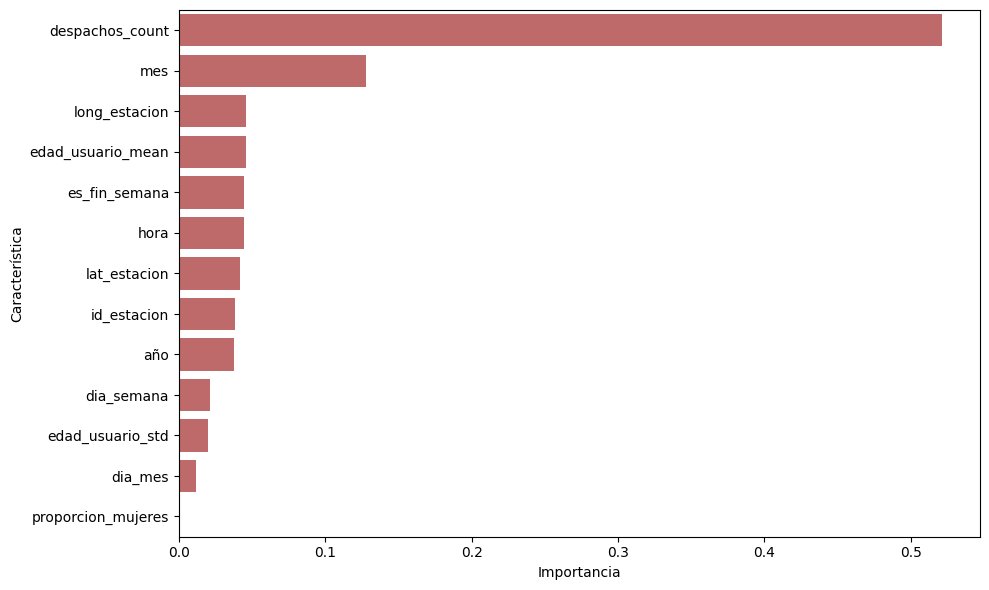

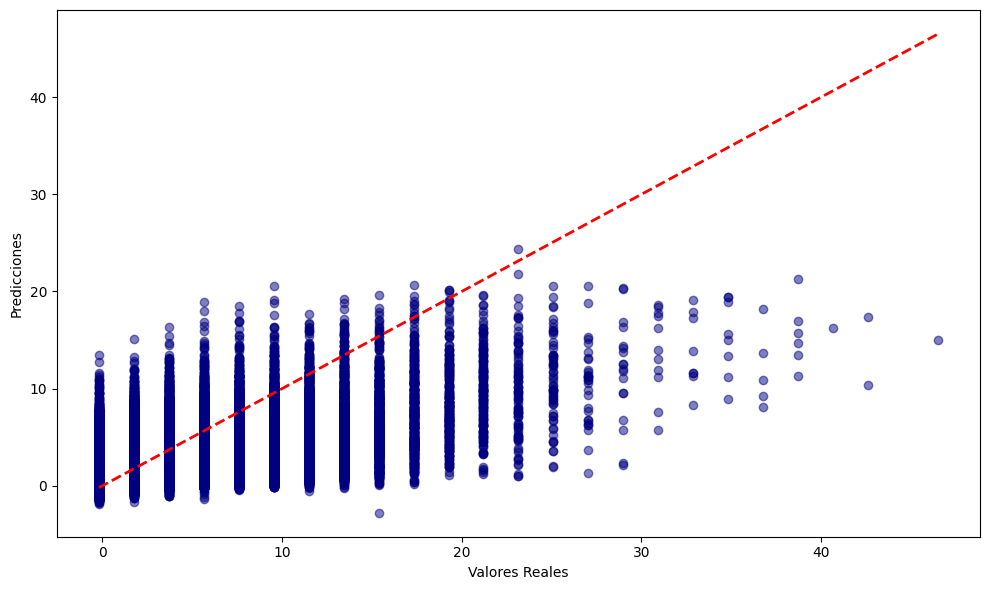


🏆 TOP 5 MEJORES ESTACIONES (R2):
                MSE       MAE        R2
-0.628443  2.938076  0.626014  0.691285
-0.323424  3.012189  0.585354  0.660961
-1.673295  2.850742  0.651292  0.653447
-1.575948  2.303499  0.565285  0.642478
 1.584565  0.637600  0.143369  0.640966

⚠️ TOP 5 PEORES ESTACIONES (R2):
                MSE       MAE            R2
-0.037875  0.003231  0.024316 -4.194095e+30
 0.857712  0.010968  0.030085 -2.471127e-01
 0.968038  0.011075  0.031068 -2.187044e-01
 1.662442  0.010874  0.021304 -1.567852e-01
 0.065961  0.029915  0.059357 -1.502722e-01


In [20]:
# ================================================================
# 📊 VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_norm['id_estacion'].unique():
    mask = val_norm['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

In [5]:
train_norm = pd.read_csv('data/processed/train_norm.csv')
val_norm = pd.read_csv('data/processed/val_norm.csv')

# Modelo M1
### Agregar features de intervalos previos y cluster geografico

🔄 Aplicando clustering geográfico a datasets...
📊 Procesando dataset de entrenamiento...
✅ Clusters geográficos creados:
   • Número de clusters: 12
   • Coordenadas únicas procesadas: 391
   • Clusters únicos: 12
   • Distribución de clusters:
cluster_geo
4     2856117
1     2425005
2     2209449
5     1993893
11    1778337
10    1778337
9     1778337
3     1562781
0     1508892
7     1455003
Name: count, dtype: int64


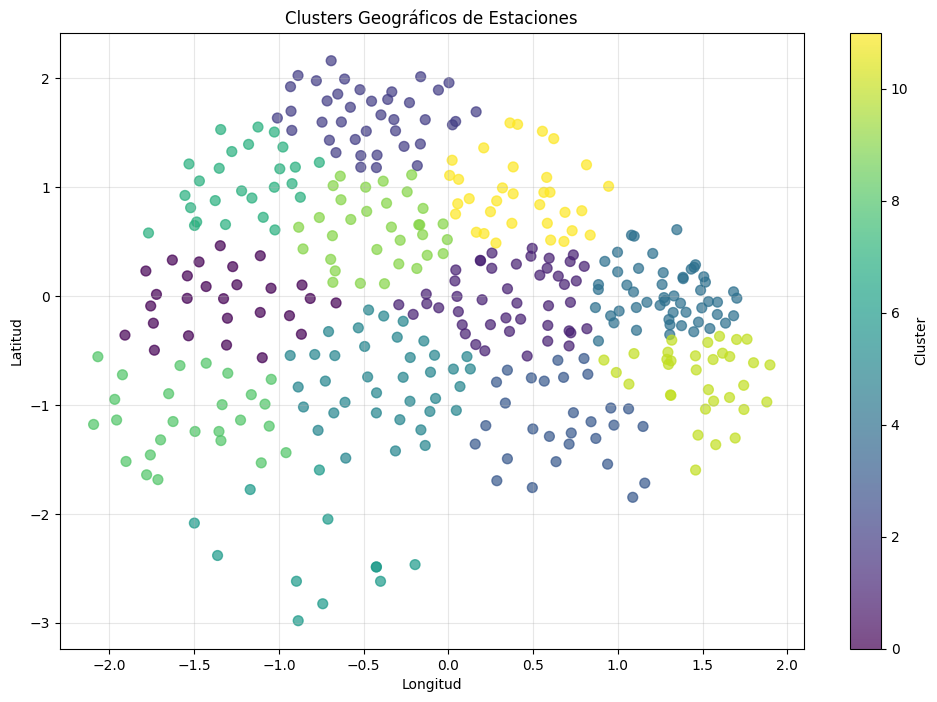

📊 Procesando dataset de validación...
✅ Clusters geográficos creados:
   • Número de clusters: 12
   • Coordenadas únicas procesadas: 391
   • Clusters únicos: 12
   • Distribución de clusters:
cluster_geo
4     585120
1     496800
2     452640
5     408480
11    364320
10    364320
9     364320
3     320160
0     309120
7     298080
Name: count, dtype: int64


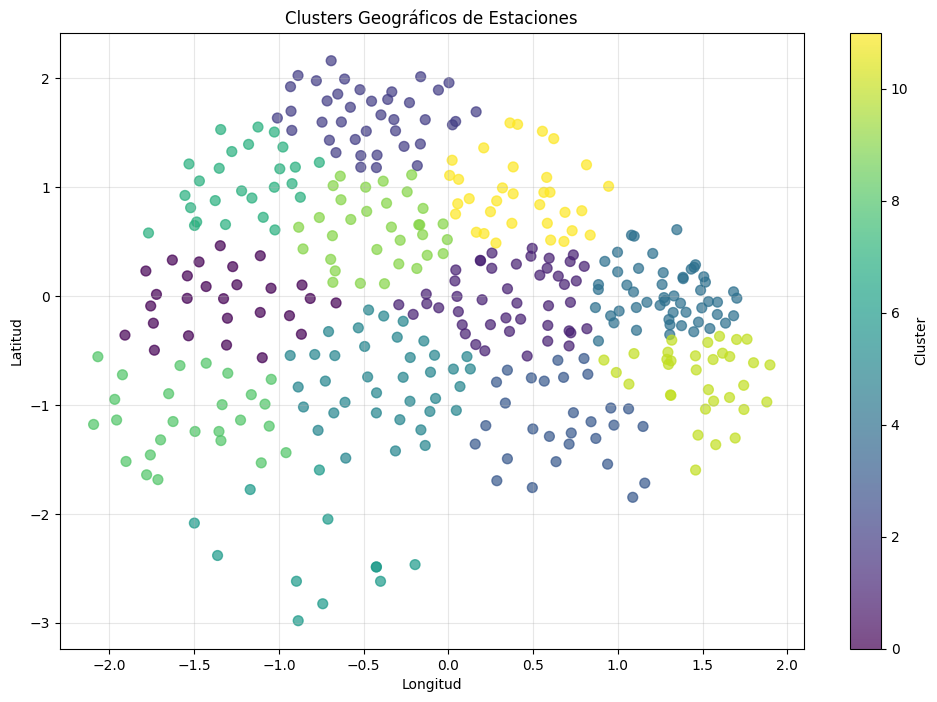


🎯 Análisis de distribución de clusters:
TRAIN - Top 10 clusters más frecuentes:
cluster_geo
4     2856117
1     2425005
2     2209449
5     1993893
11    1778337
10    1778337
9     1778337
3     1562781
0     1508892
7     1455003
Name: count, dtype: int64

VAL - Top 10 clusters más frecuentes:
cluster_geo
4     585120
1     496800
2     452640
5     408480
11    364320
10    364320
9     364320
3     320160
0     309120
7     298080
Name: count, dtype: int64


In [6]:
# Crear feature cluster_geo usando K-means para clustering geográfico
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Función para crear clusters geográficos
def create_geo_clusters(df, n_clusters=12):
    """
    Crea clusters geográficos basados en coordenadas de estaciones
    
    Args:
        df: DataFrame con columnas lat_estacion y long_estacion
        n_clusters: Número de clusters a crear (default: 12)
    
    Returns:
        DataFrame con nueva columna 'cluster_geo'
    """
    df_clustered = df.copy()
    
    # Extraer coordenadas únicas
    coords = df[['lat_estacion', 'long_estacion']].drop_duplicates().values
    
    # Aplicar K-means a las coordenadas únicas
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(coords)
    
    # Crear mapeo de coordenadas a clusters
    coord_to_cluster = {}
    for i, coord in enumerate(coords):
        cluster_label = kmeans.labels_[i]
        coord_key = (round(coord[0], 6), round(coord[1], 6))  # Redondear para evitar problemas de precisión
        coord_to_cluster[coord_key] = cluster_label
    
    # Asignar clusters a cada fila del dataset
    df_clustered['cluster_geo'] = df.apply(
        lambda row: coord_to_cluster.get(
            (round(row['lat_estacion'], 6), round(row['long_estacion'], 6)), 
            -1  # Cluster -1 para coordenadas no encontradas
        ), axis=1
    )
    
    print(f"✅ Clusters geográficos creados:")
    print(f"   • Número de clusters: {n_clusters}")
    print(f"   • Coordenadas únicas procesadas: {len(coords)}")
    print(f"   • Clusters únicos: {df_clustered['cluster_geo'].nunique()}")
    print(f"   • Distribución de clusters:")
    print(df_clustered['cluster_geo'].value_counts().head(10))
    
    # Visualizar clusters geográficos
    coords_df = pd.DataFrame(coords, columns=['lat', 'long'])
    coords_df['cluster'] = kmeans.labels_
    
    plt.figure(figsize=(12, 8))
    plt.scatter(coords_df['long'], coords_df['lat'], 
               c=coords_df['cluster'], cmap='viridis', alpha=0.7, s=50)
    plt.title('Clusters Geográficos de Estaciones')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.colorbar(label='Cluster')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return df_clustered, kmeans

# Aplicar clustering a datasets de train y val
print("🔄 Aplicando clustering geográfico a datasets...")

# Verificar que existan las variables train y val
if 'train_norm' in locals() or 'train_norm' in globals():
    print("📊 Procesando dataset de entrenamiento...")
    train_clustered, kmeans_model = create_geo_clusters(train_norm, n_clusters=12)
    train = train_clustered  # Actualizar train con clusters
    
    print("📊 Procesando dataset de validación...")
    val_clustered, _ = create_geo_clusters(val_norm, n_clusters=12)
    val = val_clustered  # Actualizar val con clusters
    
    print("\n🎯 Análisis de distribución de clusters:")
    print("TRAIN - Top 10 clusters más frecuentes:")
    print(train['cluster_geo'].value_counts().head(10))
    
    print("\nVAL - Top 10 clusters más frecuentes:")
    print(val['cluster_geo'].value_counts().head(10))
    
else:
    print("❌ Variables 'train' y 'val' no encontradas. Asegúrate de cargar los datasets primero.")


In [7]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando distribución de Poisson.
    """
    print("\n🚀 Entrenando modelo XGBoost...")
    xgb_params = {
        'n_estimators': 1000,  # Aumentamos para dar margen al early stopping
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',  # Métrica a monitorear para early stopping
        'max_bin': 128, 
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=25,
    verbose=True
    )
    print(f"✅ Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n📈 Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n📊 MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
# 🚀 PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST\n" + "="*60)

# drop nombre_estacion: object, direccion_estacion: object, modelo_mas_comun: object
train_norm = train_norm.drop(columns=[col for col in train_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_norm = val_norm.drop(columns=[col for col in val_norm.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_norm, val_norm)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)

# 4. Guardar modelo
print("\n💾 Guardando modelo...")
model_info = {
    'model': model,
    'features': feature_cols,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': metrics
}
with open('data/processed/xgb_model_single_output.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✅ Modelo guardado en data/processed/xgb_model_single_output.pkl")


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', 'arribos_coun

c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.08526
[1]	validation_0-rmse:1.05856
[2]	validation_0-rmse:1.03395
[3]	validation_0-rmse:1.01124
[4]	validation_0-rmse:0.99000
[5]	validation_0-rmse:0.97048
[6]	validation_0-rmse:0.95226
[7]	validation_0-rmse:0.93573
[8]	validation_0-rmse:0.92023
[9]	validation_0-rmse:0.90594
[10]	validation_0-rmse:0.89289
[11]	validation_0-rmse:0.88080
[12]	validation_0-rmse:0.86961
[13]	validation_0-rmse:0.85936
[14]	validation_0-rmse:0.84987
[15]	validation_0-rmse:0.84119
[16]	validation_0-rmse:0.83323
[17]	validation_0-rmse:0.82590
[18]	validation_0-rmse:0.81920
[19]	validation_0-rmse:0.81303
[20]	validation_0-rmse:0.80759
[21]	validation_0-rmse:0.80238
[22]	validation_0-rmse:0.79782
[23]	validation_0-rmse:0.79367
[24]	validation_0-rmse:0.78956
[25]	validation_0-rmse:0.78573
[26]	validation_0-rmse:0.78220
[27]	validation_0-rmse:0.77929
[28]	validation_0-rmse:0.77661
[29]	validation_0-rmse:0.77415
[30]	validation_0-rmse:0.77159
[31]	validation_0-rmse:0.76952
[32]	validation_0-


GENERANDO VISUALIZACIONES DE RESULTADOS


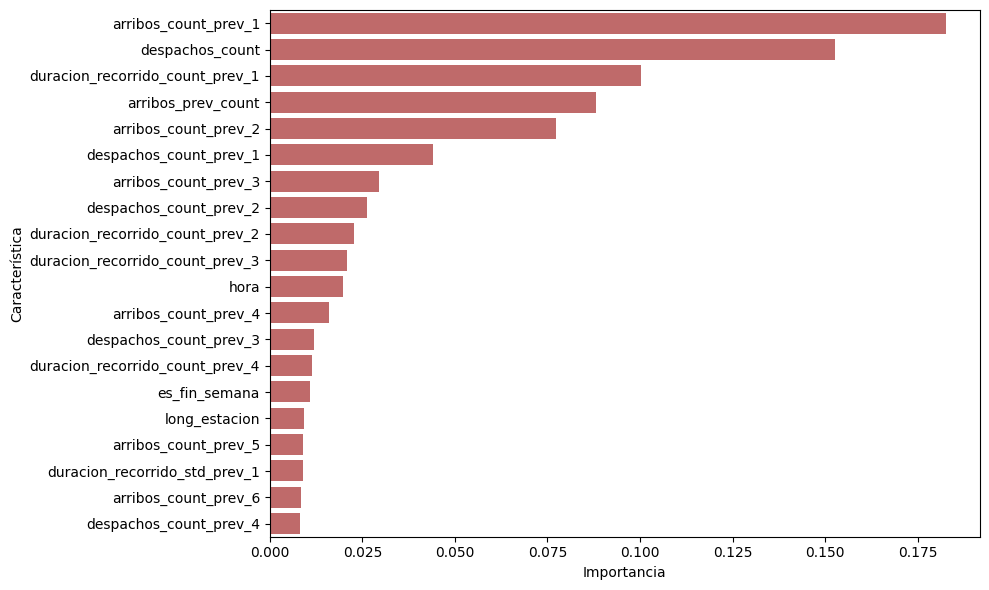

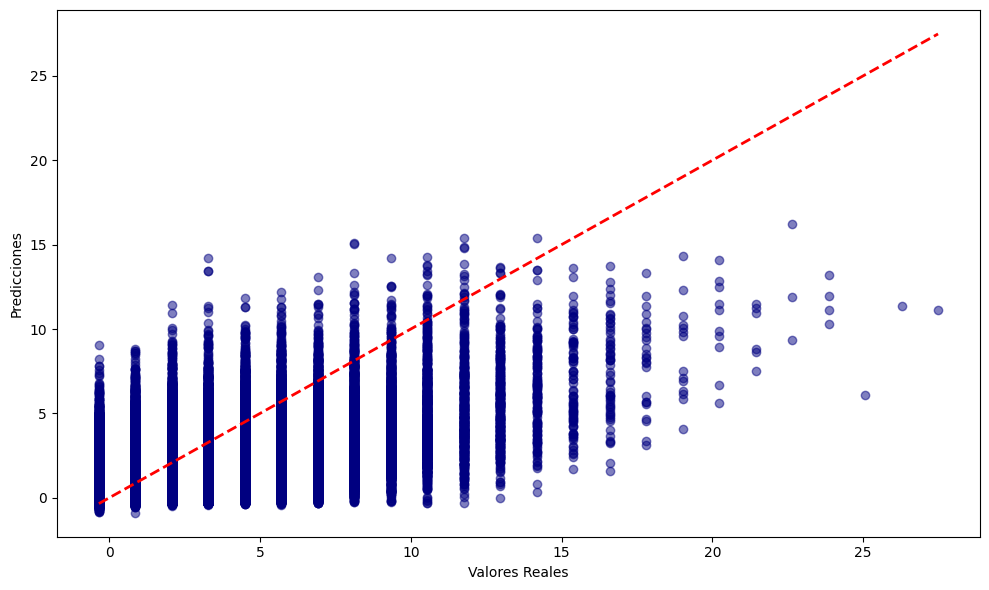


🏆 TOP 5 MEJORES ESTACIONES (R2):
                MSE       MAE        R2
-0.662120  2.511170  0.866800  0.675501
 1.355797  0.617919  0.226355  0.642916
-0.928415  1.818653  0.715474  0.636632
-0.383991  2.031319  0.743285  0.621931
-1.579356  0.470165  0.235036  0.613047

⚠️ TOP 5 PEORES ESTACIONES (R2):
                MSE       MAE         R2
 0.296538  0.001855  0.031668 -12.988031
 1.574750  0.000293  0.009189  -1.211909
 0.947479  0.002791  0.027296  -1.106397
 1.539244  0.000673  0.011532  -0.691234
-1.076356  0.005149  0.035479  -0.620012


In [8]:
# ================================================================
# 📊 VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_norm['id_estacion'].unique():
    mask = val_norm['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import time
import pickle
from datetime import datetime

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    # Chequeo de no-negatividad
    assert (y_train >= 0).all(), "y_train contiene valores negativos, Poisson no lo soporta."
    assert (y_val >= 0).all(), "y_val contiene valores negativos, Poisson no lo soporta."
    
    return X_train, y_train, X_val, y_val, feature_cols

def train_xgboost_model(X_train, y_train, X_val, y_val):
    """
    Entrena un modelo XGBoost para regresión usando Poisson como función de pérdida.
    """
    print("\n🚀 Entrenando modelo XGBoost con pérdida Poisson...")

    xgb_params = {
        'n_estimators': 1500,
        'max_depth': 10,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': 16,
        'verbosity': 1,
        'tree_method': 'gpu_hist',  # Cambiar a 'hist' si no tenés GPU
        'eval_metric': 'rmse',
        'max_bin': 128,
        'objective': 'count:poisson',  # <= CAMBIO CLAVE
    }

    model = xgb.XGBRegressor(**xgb_params)

    start = time.time()
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=25,
        verbose=True
    )
    print(f"✅ Modelo entrenado en {time.time() - start:.2f} segundos")

    return model

def evaluate_model(model, X_train, y_train, X_val, y_val):
    """
    Evalúa el modelo en train y validación.
    """
    print("\n📈 Evaluando modelo...")

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    metrics = {
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_mse': mean_squared_error(y_val, y_val_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'val_r2': r2_score(y_val, y_val_pred),
    }

    print(f"\n📊 MÉTRICAS")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics, y_val_pred

# ================================================================
# 🚀 PIPELINE
# ================================================================
print("INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST CON POISSON\n" + "="*60)

# drop columnas innecesarias
train_raw = train_raw.drop(columns=[col for col in train_raw.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])
val_raw = val_raw.drop(columns=[col for col in val_raw.columns if col.startswith('nombre_estacion') or col.startswith('direccion_estacion') or col.startswith('modelo_mas_comun')])

# 1. Preparar datos
X_train, y_train, X_val, y_val, feature_cols = prepare_features_and_target(train_raw, val_raw)

# 2. Entrenar modelo
model = train_xgboost_model(X_train, y_train, X_val, y_val)

# 3. Evaluar modelo
metrics, y_val_pred = evaluate_model(model, X_train, y_train, X_val, y_val)

# 4. Guardar modelo
print("\n💾 Guardando modelo...")
model_info = {
    'model': model,
    'features': feature_cols,
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': metrics
}
with open('data/processed/xgb_model_poisson.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("✅ Modelo guardado en data/processed/xgb_model_poisson.pkl")


INICIANDO PIPELINE DE ENTRENAMIENTO XGBOOST CON POISSON
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', '

c:\Users\Matteo\anaconda3\envs\mldl_clean\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.84009
[1]	validation_0-rmse:0.83105
[2]	validation_0-rmse:0.82243
[3]	validation_0-rmse:0.81418
[4]	validation_0-rmse:0.80615
[5]	validation_0-rmse:0.79848
[6]	validation_0-rmse:0.79101
[7]	validation_0-rmse:0.78397
[8]	validation_0-rmse:0.77708
[9]	validation_0-rmse:0.77046
[10]	validation_0-rmse:0.76415
[11]	validation_0-rmse:0.75805
[12]	validation_0-rmse:0.75218
[13]	validation_0-rmse:0.74657
[14]	validation_0-rmse:0.74114
[15]	validation_0-rmse:0.73590
[16]	validation_0-rmse:0.73089
[17]	validation_0-rmse:0.72608
[18]	validation_0-rmse:0.72146
[19]	validation_0-rmse:0.71702
[20]	validation_0-rmse:0.71285
[21]	validation_0-rmse:0.70876
[22]	validation_0-rmse:0.70494
[23]	validation_0-rmse:0.70129
[24]	validation_0-rmse:0.69765
[25]	validation_0-rmse:0.69416
[26]	validation_0-rmse:0.69079
[27]	validation_0-rmse:0.68770
[28]	validation_0-rmse:0.68470
[29]	validation_0-rmse:0.68184
[30]	validation_0-rmse:0.67897
[31]	validation_0-rmse:0.67634
[32]	validation_0-


GENERANDO VISUALIZACIONES DE RESULTADOS


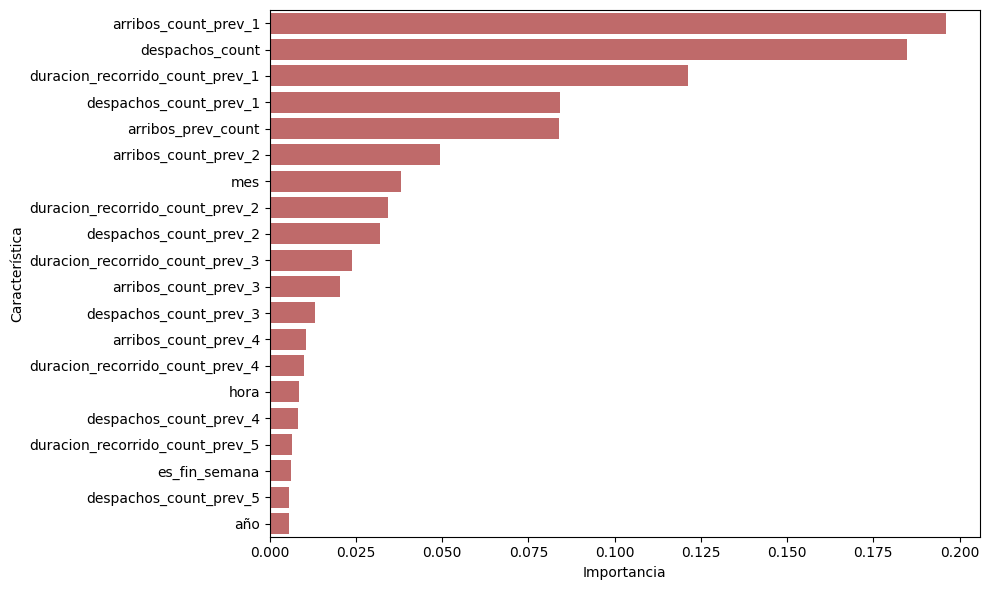

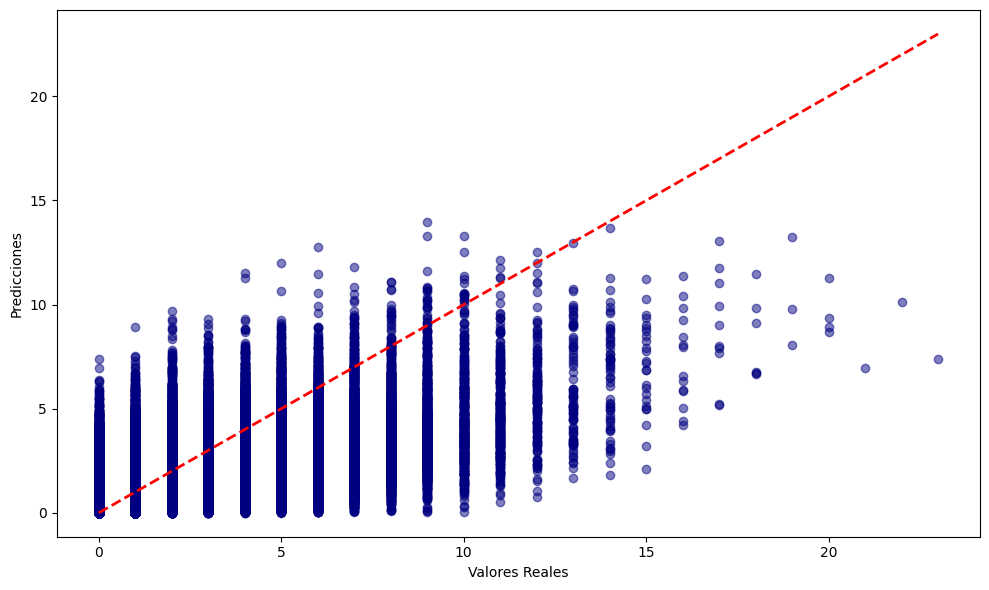


🏆 TOP 5 MEJORES ESTACIONES (R2):
          MSE       MAE        R2
175  1.713904  0.708073  0.675690
516  0.417016  0.179189  0.647118
130  1.235026  0.576868  0.638664
222  1.364757  0.604764  0.628048
20   0.313746  0.177314  0.621885

⚠️ TOP 5 PEORES ESTACIONES (R2):
          MSE       MAE        R2
337  0.000298  0.010220 -2.291708
447  0.000985  0.007506 -0.088659
547  0.000277  0.001080 -0.019021
541  0.009282  0.004372 -0.014996
556  0.000272  0.000597 -0.002424


In [10]:
# ================================================================
# 📊 VISUALIZACIÓN DE RESULTADOS
# ================================================================
print("\nGENERANDO VISUALIZACIONES DE RESULTADOS\n" + "="*60)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Importancia de características
importancia = pd.DataFrame({
    'caracteristica': feature_cols,
    'importancia': model.feature_importances_
})
importancia = importancia.sort_values('importancia', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importancia.head(20), x='importancia', y='caracteristica',color='indianred')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10,6))
plt.scatter(y_val, y_val_pred, alpha=0.5,color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones') 
plt.tight_layout()
plt.show()

# 4. Métricas por estación
metricas_estacion = pd.DataFrame()
for estacion in val_raw['id_estacion'].unique():
    mask = val_raw['id_estacion'] == estacion
    y_real = y_val[mask]
    y_pred = y_val_pred[mask]
    
    metricas_estacion.loc[estacion, 'MSE'] = mean_squared_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'MAE'] = mean_absolute_error(y_real, y_pred)
    metricas_estacion.loc[estacion, 'R2'] = r2_score(y_real, y_pred)

# Top 5 mejores y peores estaciones según R2
print("\n🏆 TOP 5 MEJORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2', ascending=False).head())

print("\n⚠️ TOP 5 PEORES ESTACIONES (R2):")
print(metricas_estacion.sort_values('R2').head())

In [13]:

## 🚀 Modelo LightGBM

# Entrenar modelo LightGBM con train_norm y val_norm
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

print("🔄 ENTRENANDO MODELO LIGHTGBM")
print("="*60)

def prepare_features_and_target(train_df, val_df):
    """
    Prepara X e y para entrenamiento, dejando id_estacion como feature numérica.
    """
    print("Preparando features y target...")

    feature_cols = [col for col in train_df.columns if col not in ['timestamp', 'arribos_count','duracion_recorrido_mean','duracion_recorrido_std','duracion_recorrido_count']]
    
    X_train = train_df[feature_cols]
    y_train = train_df['arribos_count']
    
    X_val = val_df[feature_cols]
    y_val = val_df['arribos_count']
    
    print(f"Features: {feature_cols}")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
    
    # Chequeo de no-negatividad
    # assert (y_train >= 0).all(), "y_train contiene valores negativos, Poisson no lo soporta."
    # assert (y_val >= 0).all(), "y_val contiene valores negativos, Poisson no lo soporta."
    
    return X_train, y_train, X_val, y_val, feature_cols
# Preparar datos usando la función existente (sin MultiOutput)
X_train_lgb, y_train_lgb, X_val_lgb, y_val_lgb, feature_cols_lgb = prepare_features_and_target(train_norm, val_norm)

# Configuración de LightGBM
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42,
    'n_estimators': 1000,
    'device': 'gpu'  # Cambiar a 'cpu' si no tienes GPU
}

print("📊 Configuración LightGBM:")
for param, value in lgb_params.items():
    print(f"  {param}: {value}")

print(f"\n📏 Dimensiones de datos:")
print(f"  X_train: {X_train_lgb.shape}")
print(f"  y_train: {y_train_lgb.shape}")
print(f"  X_val: {X_val_lgb.shape}")
print(f"  y_val: {y_val_lgb.shape}")

# Crear modelo LightGBM (regresión simple, no MultiOutput)
lgb_model = lgb.LGBMRegressor(**lgb_params)

print(f"\n🚀 Iniciando entrenamiento...")
start_time = time.time()

# Entrenar el modelo
lgb_model.fit(X_train_lgb, y_train_lgb)

training_time = time.time() - start_time
print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")

# Evaluación
print(f"\n📊 EVALUANDO MODELO LIGHTGBM...")

# Predicciones
y_train_pred_lgb = lgb_model.predict(X_train_lgb)
y_val_pred_lgb = lgb_model.predict(X_val_lgb)

# Métricas
train_mse_lgb = mean_squared_error(y_train_lgb, y_train_pred_lgb)
train_mae_lgb = mean_absolute_error(y_train_lgb, y_train_pred_lgb)
train_r2_lgb = r2_score(y_train_lgb, y_train_pred_lgb)

val_mse_lgb = mean_squared_error(y_val_lgb, y_val_pred_lgb)
val_mae_lgb = mean_absolute_error(y_val_lgb, y_val_pred_lgb)
val_r2_lgb = r2_score(y_val_lgb, y_val_pred_lgb)

print(f"\n📈 RESULTADOS LIGHTGBM:")
print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
print("-" * 50)
print(f"{'Train':<12} {train_mse_lgb:<12.4f} {train_mae_lgb:<12.4f} {train_r2_lgb:<12.4f}")
print(f"{'Validación':<12} {val_mse_lgb:<12.4f} {val_mae_lgb:<12.4f} {val_r2_lgb:<12.4f}")

# Análisis de overfitting
overfitting_mse_lgb = (train_mse_lgb - val_mse_lgb) / val_mse_lgb * 100
overfitting_mae_lgb = (train_mae_lgb - val_mae_lgb) / val_mae_lgb * 100

print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
print(f"Diferencia MSE: {overfitting_mse_lgb:.2f}% ({'Overfitting' if overfitting_mse_lgb < -10 else 'OK'})")
print(f"Diferencia MAE: {overfitting_mae_lgb:.2f}% ({'Overfitting' if overfitting_mae_lgb < -10 else 'OK'})")

# Análisis de feature importance
print(f"\n📊 TOP 15 FEATURES MÁS IMPORTANTES:")
feature_importance = lgb_model.feature_importances_
feature_names = X_train_lgb.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(importance_df.head(15).iterrows()):
    print(f"  {i+1:2d}. {row['feature'][:40]:<40} {row['importance']:.4f}")

print(f"\n✅ LIGHTGBM COMPLETADO - R² en validación: {val_r2_lgb:.4f}")

🔄 ENTRENANDO MODELO LIGHTGBM
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', 'arribos_count_prev_3', 'des

In [21]:

## 🧠 Red Neuronal

# Entrenar una red neuronal con train_norm y val_norm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler

print("🔄 ENTRENANDO RED NEURONAL")
print("="*60)

# Preparar datos usando la función existente (regresión simple)
X_train_nn, y_train_nn, X_val_nn, y_val_nn, feature_cols_nn = prepare_features_and_target(train_norm, val_norm)

print(f"📏 Dimensiones de datos:")
print(f"  X_train: {X_train_nn.shape}")
print(f"  y_train: {y_train_nn.shape}")
print(f"  X_val: {X_val_nn.shape}")
print(f"  y_val: {y_val_nn.shape}")

# Definir arquitectura de la red neuronal (regresión simple)
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.3):
        super(SimpleMLP, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Capas ocultas
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Capa de salida (una sola neurona para regresión)
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x).squeeze(-1)  # Remover la última dimensión

# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_nn.values)
y_train_tensor = torch.FloatTensor(y_train_nn.values)
X_val_tensor = torch.FloatTensor(X_val_nn.values)
y_val_tensor = torch.FloatTensor(y_val_nn.values)

# Configuración del modelo
input_size = X_train_nn.shape[1]
hidden_sizes = [512, 256, 128]  # Capas ocultas
batch_size = 256
learning_rate = 0.001
num_epochs = 50

print(f"🏗️ Arquitectura de la Red:")
print(f"  Input size: {input_size}")
print(f"  Hidden layers: {hidden_sizes}")
print(f"  Output size: 1 (regresión simple)")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")

# Crear datasets y dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Inicializar modelo, loss y optimizador
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Usando dispositivo: {device}")

model_nn = SimpleMLP(input_size, hidden_sizes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

print(f"\n🚀 Iniciando entrenamiento...")
start_time = time.time()

# Listas para guardar pérdidas
train_losses = []
val_losses = []

# Entrenamiento
for epoch in range(num_epochs):
    # Entrenamiento
    model_nn.train()
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model_nn(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validación
    model_nn.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model_nn(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    # Calcular pérdidas promedio
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Learning rate scheduler
    scheduler.step(avg_val_loss)
    
    # Imprimir progreso cada 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

training_time = time.time() - start_time
print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")

# Evaluación final
print(f"\n📊 EVALUANDO RED NEURONAL...")

model_nn.eval()
with torch.no_grad():
    # Predicciones en train
    X_train_tensor = X_train_tensor.to(device)
    y_train_pred_nn = model_nn(X_train_tensor).cpu().numpy()
    
    # Predicciones en validación
    X_val_tensor = X_val_tensor.to(device)
    y_val_pred_nn = model_nn(X_val_tensor).cpu().numpy()

# Convertir a numpy para métricas
y_train_true = y_train_nn.values
y_val_true = y_val_nn.values

# Métricas
train_mse_nn = mean_squared_error(y_train_true, y_train_pred_nn)
train_mae_nn = mean_absolute_error(y_train_true, y_train_pred_nn)
train_r2_nn = r2_score(y_train_true, y_train_pred_nn)

val_mse_nn = mean_squared_error(y_val_true, y_val_pred_nn)
val_mae_nn = mean_absolute_error(y_val_true, y_val_pred_nn)
val_r2_nn = r2_score(y_val_true, y_val_pred_nn)

print(f"\n📈 RESULTADOS RED NEURONAL:")
print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
print("-" * 50)
print(f"{'Train':<12} {train_mse_nn:<12.4f} {train_mae_nn:<12.4f} {train_r2_nn:<12.4f}")
print(f"{'Validación':<12} {val_mse_nn:<12.4f} {val_mae_nn:<12.4f} {val_r2_nn:<12.4f}")

# Análisis de overfitting
overfitting_mse_nn = (train_mse_nn - val_mse_nn) / val_mse_nn * 100
overfitting_mae_nn = (train_mae_nn - val_mae_nn) / val_mae_nn * 100

print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
print(f"Diferencia MSE: {overfitting_mse_nn:.2f}% ({'Overfitting' if overfitting_mse_nn < -10 else 'OK'})")
print(f"Diferencia MAE: {overfitting_mae_nn:.2f}% ({'Overfitting' if overfitting_mae_nn < -10 else 'OK'})")

print(f"\n✅ RED NEURONAL COMPLETADA - R² en validación: {val_r2_nn:.4f}")

🔄 ENTRENANDO RED NEURONAL
Preparando features y target...


MemoryError: Unable to allocate 1.83 GiB for an array with shape (56, 4382880) and data type float64

In [20]:
import gc
gc.collect()

0

In [15]:
## 🎯 XGBoost para Una Estación Específica

# Entrenar modelo XGBoost solo para una estación específica
import xgboost as xgb
import pandas as pd
import numpy as np

print("🔄 ENTRENANDO XGBOOST PARA UNA ESTACIÓN ESPECÍFICA")
print("="*60)

# Preparar datos usando la función existente (regresión simple)
X_train_single, y_train_single, X_val_single, y_val_single, feature_cols_single = prepare_features_and_target(train_norm, val_norm)

# Seleccionar la estación con más arribos para el análisis
# Agrupar por estación y calcular total de arribos
train_by_station = X_train_single.groupby('id_estacion')['id_estacion'].count()
station_counts = train_by_station.sort_values(ascending=False)
# target_station_id = station_counts.index[0]  # Estación con más registros
target_station_id = 175

print(f"🎯 Estación seleccionada: {target_station_id}")
print(f"   Total registros en train: {station_counts.iloc[0]:.0f}")

# Filtrar datos solo para esta estación
mask_train = X_train_single['id_estacion'] == target_station_id
mask_val = X_val_single['id_estacion'] == target_station_id

X_train_station = X_train_single[mask_train]
y_train_station = y_train_single[mask_train]
X_val_station = X_val_single[mask_val]
y_val_station = y_val_single[mask_val]

print(f"\n📏 Dimensiones de datos para estación {target_station_id}:")
print(f"  X_train (estación): {X_train_station.shape}")
print(f"  y_train (estación): {y_train_station.shape}")
print(f"  X_val (estación): {X_val_station.shape}")
print(f"  y_val (estación): {y_val_station.shape}")

# Estadísticas de la estación seleccionada
print(f"\n📊 Estadísticas de la estación {target_station_id}:")
print(f"  Train - Media: {y_train_station.mean():.2f}, Std: {y_train_station.std():.2f}")
print(f"  Train - Min: {y_train_station.min():.0f}, Max: {y_train_station.max():.0f}")
print(f"  Val - Media: {y_val_station.mean():.2f}, Std: {y_val_station.std():.2f}")
print(f"  Val - Min: {y_val_station.min():.0f}, Max: {y_val_station.max():.0f}")

# Configuración específica de XGBoost para una sola estación
xgb_single_params = {
    'n_estimators': 500,           # Más árboles ya que es un solo target
    'max_depth': 8,                # Mayor profundidad
    'learning_rate': 0.05,         # Learning rate más bajo
    'subsample': 0.8,              
    'colsample_bytree': 0.8,       
    'random_state': 42,            
    'n_jobs': 8,                  
    'verbosity': 1,                
    'tree_method': 'gpu_hist',     # Cambiar a 'hist' si no tienes GPU
    'eval_metric': 'rmse',
    'early_stopping_rounds': 50
}

print(f"\n🔧 Configuración XGBoost (estación específica):")
for param, value in xgb_single_params.items():
    print(f"  {param}: {value}")

# Crear el modelo XGBoost
xgb_single_model = xgb.XGBRegressor(**xgb_single_params)

print(f"\n🚀 Iniciando entrenamiento...")
start_time = time.time()

# Entrenar con early stopping
xgb_single_model.fit(
    X_train_station, y_train_station,
    eval_set=[(X_val_station, y_val_station)],
    verbose=False
)

training_time = time.time() - start_time
print(f"✅ Entrenamiento completado en {training_time:.2f} segundos")
print(f"  Mejor iteración: {xgb_single_model.best_iteration}")
print(f"  Score en validación: {xgb_single_model.best_score:.4f}")

# Evaluación
print(f"\n📊 EVALUANDO MODELO PARA ESTACIÓN {target_station_id}...")

# Predicciones
y_train_pred_single = xgb_single_model.predict(X_train_station)
y_val_pred_single = xgb_single_model.predict(X_val_station)

# Métricas
train_mse_single = mean_squared_error(y_train_station, y_train_pred_single)
train_mae_single = mean_absolute_error(y_train_station, y_train_pred_single)
train_r2_single = r2_score(y_train_station, y_train_pred_single)

val_mse_single = mean_squared_error(y_val_station, y_val_pred_single)
val_mae_single = mean_absolute_error(y_val_station, y_val_pred_single)
val_r2_single = r2_score(y_val_station, y_val_pred_single)

print(f"\n📈 RESULTADOS XGBOOST ESTACIÓN {target_station_id}:")
print(f"{'Conjunto':<12} {'MSE':<12} {'MAE':<12} {'R²':<12}")
print("-" * 50)
print(f"{'Train':<12} {train_mse_single:<12.4f} {train_mae_single:<12.4f} {train_r2_single:<12.4f}")
print(f"{'Validación':<12} {val_mse_single:<12.4f} {val_mae_single:<12.4f} {val_r2_single:<12.4f}")

# Análisis de overfitting
overfitting_mse_single = (train_mse_single - val_mse_single) / val_mse_single * 100
overfitting_mae_single = (train_mae_single - val_mae_single) / val_mae_single * 100

print(f"\n🔍 ANÁLISIS DE OVERFITTING:")
print(f"Diferencia MSE: {overfitting_mse_single:.2f}% ({'Overfitting' if overfitting_mse_single < -10 else 'OK'})")
print(f"Diferencia MAE: {overfitting_mae_single:.2f}% ({'Overfitting' if overfitting_mae_single < -10 else 'OK'})")

# Análisis de feature importance
print(f"\n📊 TOP 15 FEATURES MÁS IMPORTANTES:")
feature_importance = xgb_single_model.feature_importances_
feature_names = X_train_station.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(importance_df.head(15).iterrows()):
    print(f"  {i+1:2d}. {row['feature'][:40]:<40} {row['importance']:.4f}")

# Análisis de predicciones
print(f"\n🎯 ANÁLISIS DE PREDICCIONES:")
print(f"  Predicción promedio (train): {y_train_pred_single.mean():.2f}")
print(f"  Predicción promedio (val): {y_val_pred_single.mean():.2f}")
print(f"  Real promedio (train): {y_train_station.mean():.2f}")
print(f"  Real promedio (val): {y_val_station.mean():.2f}")

# Análisis de residuos
residuals_train = y_train_station - y_train_pred_single
residuals_val = y_val_station - y_val_pred_single

print(f"\n📏 ANÁLISIS DE RESIDUOS:")
print(f"  Train - Media: {residuals_train.mean():.4f}, Std: {residuals_train.std():.4f}")
print(f"  Val - Media: {residuals_val.mean():.4f}, Std: {residuals_val.std():.4f}")

print(f"\n✅ XGBOOST ESTACIÓN ESPECÍFICA COMPLETADO - R² en validación: {val_r2_single:.4f}")

# Guardar modelo específico
import pickle
single_station_model_info = {
    'model': xgb_single_model,
    'station_id': target_station_id,
    'target_column': 'arribos_count',
    'feature_columns': list(X_train_station.columns),
    'train_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'metrics': {
        'val_mse': val_mse_single,
        'val_mae': val_mae_single, 
        'val_r2': val_r2_single
    },
    'feature_importance': importance_df.to_dict()
}

with open(f'data/processed/xgb_single_station_{target_station_id}.pkl', 'wb') as f:
    pickle.dump(single_station_model_info, f)

print(f"💾 Modelo guardado en: data/processed/xgb_single_station_{target_station_id}.pkl")


🔄 ENTRENANDO XGBOOST PARA UNA ESTACIÓN ESPECÍFICA
Preparando features y target...
Features: ['id_estacion', 'lat_estacion', 'long_estacion', 'despachos_count', 'edad_usuario_mean', 'edad_usuario_std', 'proporcion_mujeres', 'arribos_prev_count', 'hora', 'dia_semana', 'es_fin_semana', 'mes', 'dia_mes', 'año', 'despachos_count_prev_1', 'duracion_recorrido_mean_prev_1', 'duracion_recorrido_std_prev_1', 'duracion_recorrido_count_prev_1', 'edad_usuario_mean_prev_1', 'edad_usuario_std_prev_1', 'proporcion_mujeres_prev_1', 'arribos_count_prev_1', 'despachos_count_prev_2', 'duracion_recorrido_mean_prev_2', 'duracion_recorrido_std_prev_2', 'duracion_recorrido_count_prev_2', 'edad_usuario_mean_prev_2', 'edad_usuario_std_prev_2', 'proporcion_mujeres_prev_2', 'arribos_count_prev_2', 'despachos_count_prev_3', 'duracion_recorrido_mean_prev_3', 'duracion_recorrido_std_prev_3', 'duracion_recorrido_count_prev_3', 'edad_usuario_mean_prev_3', 'edad_usuario_std_prev_3', 'proporcion_mujeres_prev_3', 'arribo